In [1]:
import re
import warnings
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import scipy


from datetime import datetime
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from fbprophet import Prophet
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Загружаем датасет
df = pd.read_csv('data/08/tea_demand.csv', delimiter='\t', parse_dates=[1])

- lipton — 29;
- ahmad — 178; 
- may — 5152.

In [3]:
# Посмотрим на данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        459 non-null    int64         
 1   date            459 non-null    datetime64[ns]
 2   receipts_count  459 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.9 KB


In [4]:
df.head()

brand_id       date  receipts_count
0      5152 2016-07-01              98
1       178 2016-07-01             234
2        29 2016-07-01             622
3      5152 2016-07-02              87
4       178 2016-07-02             185

In [5]:
# Вынесем дату в индекс
df.index = df.date
df.drop(['date'], axis=1, inplace=True)

In [6]:
df.head()

brand_id  receipts_count
date                                
2016-07-01      5152              98
2016-07-01       178             234
2016-07-01        29             622
2016-07-02      5152              87
2016-07-02       178             185

In [7]:
# Преобразуем датафрейм для удобства нализа
df['lipton'] = df[df.brand_id == 29].receipts_count
df['ahmad'] = df[df.brand_id == 178].receipts_count
df['may'] = df[df.brand_id == 5152].receipts_count

df.drop(['brand_id','receipts_count'], axis=1, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df.head()

lipton  ahmad  may
date                          
2016-07-01     622    234   98
2016-07-02     580    185   87
2016-07-03     687    190  105
2016-07-04     550    196  141
2016-07-05     529    336  137

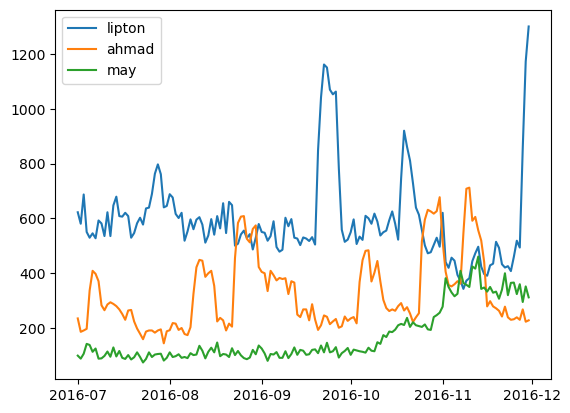

In [8]:
# Визуализируем продажи
fig, ax = plt.subplots()
ax.plot(df)
ax.legend(['lipton', 'ahmad', 'may'])
plt.show()

#### Загрузим данные о выпусках игры "Что? Где? Когда?"

In [9]:
# Задаем заголовки для requests
headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.92 Safari/537.36",
        "Accept-Encoding": "gzip, deflate, br"
    }

In [10]:
# Скомпилируем шаблон для парсинга текста
date_template = re.compile('Выпуск от (\d+\.\d+\.2016)')

In [11]:
def get_dates(date_from, date_to) -> list:
    """ Функция возвращает список выпусков игры за период """
    url = f'https://www.1tv.ru/shows/chto-gde-kogda/vypuski?order=asc&from={date_from}&to={date_to}'
    try:
        res = requests.get(url, headers=headers, timeout=5)
        if res.status_code == 200:
            soup = BeautifulSoup(res.text, 'html.parser')
            # Парсим секцию video-cards
            video_cards = soup.findAll(True, {"class":["video-cards"]})
            video_cards = video_cards[0].get_text().replace('\xa0', ' ')
            # Возвращаем список дат
            return date_template.findall(video_cards)
    except Exceptions as err:
        print(err)

In [12]:
""" При загрузке через requests, данные подгружается за полгода.
    Если требуется более длительный период, то одним из быстрых
    вариантов - сделать запрос диапазонами """

periods = ['2016-01-01', '2016-07-01', '2016-12-31']
# Даты выпуска игры будем хранить в releases
releases = []

# В нашем исходном датасете период '2016-07-01', '2016-12-31', следовательно выбираем второе полугодие
for x in range(1, 2):
    dates = get_dates(periods[x], periods[x+1])
    if dates:
        releases.extend(dates)
    else:
        raise
releases

['25.09.2016',
 '02.10.2016',
 '09.10.2016',
 '16.10.2016',
 '23.10.2016',
 '20.11.2016',
 '27.11.2016',
 '11.12.2016',
 '18.12.2016']

In [13]:
def convert_to_date(string):
    """ Функция конвертирует строку в формат date """
    return datetime.datetime.strptime(string, '%d.%m.%Y')

#### Визуальный анализ

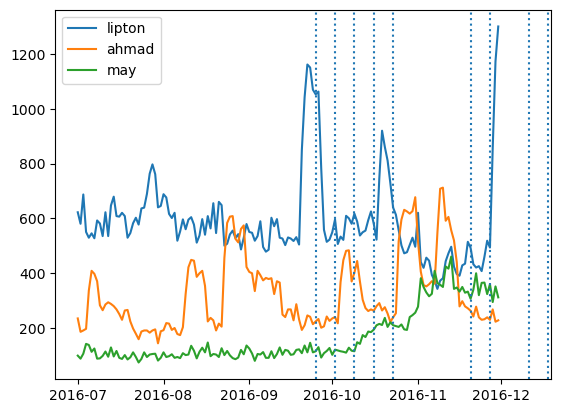

In [14]:
# Отобразим на графике выпуски игры
fig, ax = plt.subplots()
ax.plot(df)
for release in map(convert_to_date, releases):
    ax.axvline(x=release, linestyle=':')
ax.legend(['lipton', 'ahmad', 'may'])
plt.show()

На первый взгляд, какой-либо системной корреляции незаметно

Взглянем на гистограмму и boxplot

array([[<AxesSubplot:title={'center':'lipton'}>,
        <AxesSubplot:title={'center':'ahmad'}>],
       [<AxesSubplot:title={'center':'may'}>, <AxesSubplot:>]],
      dtype=object)

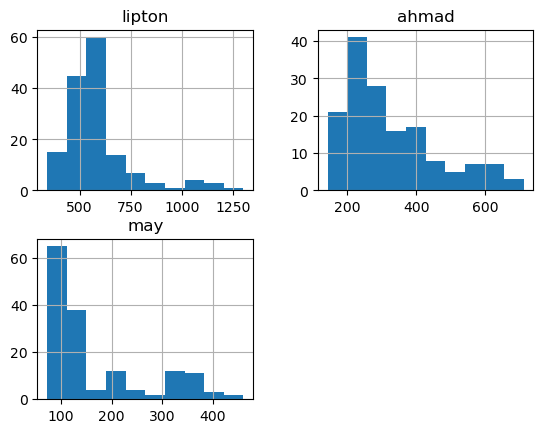

In [15]:
df.hist()

<AxesSubplot:>

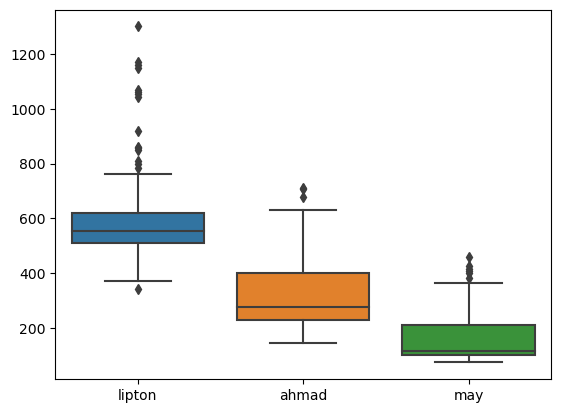

In [16]:
sns.boxplot(df)

In [17]:
iqr = scipy.stats.iqr(df.ahmad)
df[(df['ahmad']>np.percentile(df['ahmad'], 75)+1.5*iqr)]['ahmad']

date
2016-10-31    677
2016-11-09    708
2016-11-10    712
Name: ahmad, dtype: int64

Согласно полученным данным, продажи ahmad (на всём временном интервале датасета) находятся в некотором диапазоне и практически не имеют выбросов.

<AxesSubplot:xlabel='date'>

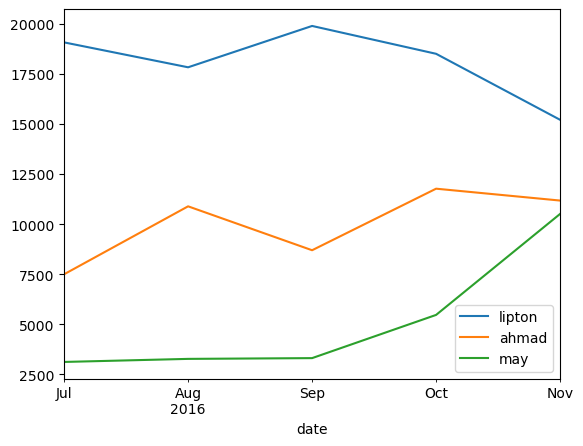

In [18]:
df.resample('M').sum().plot()

#### Воспользуемся оценкой ковариационной матрицы

In [19]:
outliers_fraction = 0.2

In [20]:
outlier_detector = EllipticEnvelope(support_fraction=1.,
                                    contamination=outliers_fraction)

outlier_detector.fit(df['ahmad'].values.reshape(-1, 1))
df['detector1'] = outlier_detector.predict(df['ahmad'].values.reshape(-1, 1))

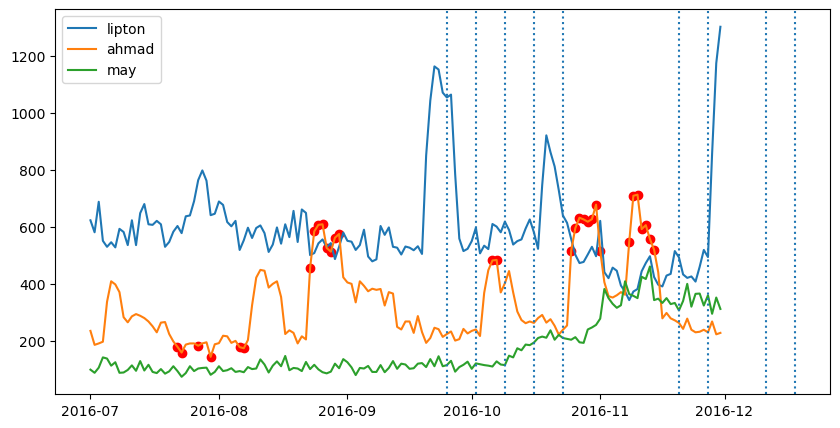

In [21]:
# Отметим точками
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df[['lipton', 'ahmad', 'may']])

for release in map(convert_to_date, releases):
    ax.axvline(x=release, linestyle=':')
    
# Отобразим полученные аномалии
a = df.loc[df['detector1'] == -1]['ahmad'].reset_index() 
plt.scatter(a['date'], a['ahmad'], color='red')

ax.legend(['lipton', 'ahmad', 'may'])
plt.show()

На грфике видно, что системные всплески (после выхода передачи) - отсутсвуют. Отдельные случаи роста продаж, это скорее совпадение с другими событиями или акциями.

#### Исследуем данные с помощью IsolationForest

In [22]:
# Добавим фичи
def create_features(df_source):
    """ Функция создаёт признаки из индекса (datetime) """
    df = df_source.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    # df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype('int64')
    return df

In [23]:
df_forest = create_features(df)

In [24]:
# Выберем интересующие нас данные
data = df_forest[['ahmad', 'dayofweek',	'quarter', 'month',	'dayofyear', 'dayofmonth', 'weekofyear']].to_numpy()
# to_numpy() - конвертация, чтобы обойти баг в sklearn

In [25]:
# Обучим модель IsolationForest
model =  IsolationForest(contamination=outliers_fraction, random_state=42).fit(data)
df['forest'] = model.predict(data)
df['forest'] = df['forest'].map( {1: 0, -1: 1} )
print(df['forest'].value_counts())

0    122
1     31
Name: forest, dtype: int64


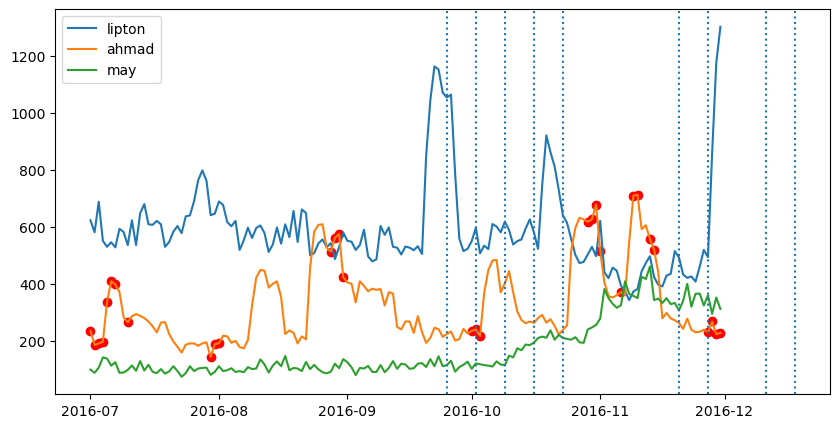

In [26]:
# Визуализируем полученные результаты
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df[['lipton', 'ahmad', 'may']])

for release in map(convert_to_date, releases):
    ax.axvline(x=release, linestyle=':')
    
# Отобразим полученные аномалии
a = df.loc[df['forest'] == 1]['ahmad'].reset_index() 
plt.scatter(a['date'], a['ahmad'], color='red')

ax.legend(['lipton', 'ahmad', 'may'])
plt.show()

Результат похож на EllipticEnvelope

#### Для анализа временных рядов воспользуемся XGBoost

In [27]:
# Добавим смещение на один день
df['ahmad_lag1'] = df['ahmad'].shift(1)

In [28]:
# Напишем функцию для подготовки тренировочных датасетов
def prepare_train_test(df_source, split_date):
    """ Функция подготовки тренировочных и валидационных данных """
    
    # Добавляем фичи
    df_w_features = create_features(df_source)
    
    # Разбиваем данные на тренировочные и валидационные
    df_train = df_w_features.loc[df_w_features.index < split_date].copy()
    df_test = df_w_features.loc[df_w_features.index >= split_date].copy()
    
    X_train, y_train = df_train.drop(['ahmad'], axis=1), df_train['ahmad']
    X_test, y_test = df_test.drop(['ahmad'], axis=1), df_test['ahmad']
    
    return df_train, df_test, X_train, y_train, X_test, y_test

In [29]:
# Делаем сплит на дате начала рекламной кампании
split_date = '2016-08-25'
# Подготовим данные
df_train, df_test, X_train, y_train, X_test, y_test = prepare_train_test(df[['ahmad', 'ahmad_lag1']], split_date)
df_train.head()

ahmad  ahmad_lag1  dayofweek  quarter  month  dayofyear  \
date                                                                  
2016-07-01    234         NaN          4        3      7        183   
2016-07-02    185       234.0          5        3      7        184   
2016-07-03    190       185.0          6        3      7        185   
2016-07-04    196       190.0          0        3      7        186   
2016-07-05    336       196.0          1        3      7        187   

            dayofmonth  weekofyear  
date                                
2016-07-01           1          26  
2016-07-02           2          26  
2016-07-03           3          26  
2016-07-04           4          27  
2016-07-05           5          27

In [30]:
# Обучим модель XGBoost
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=50)

[0]	validation_0-rmse:205.79217	validation_1-rmse:300.15317
[50]	validation_0-rmse:0.06672	validation_1-rmse:146.69202
[56]	validation_0-rmse:0.04122	validation_1-rmse:146.71668


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [31]:
# Делаем прогноз
df_test['Prediction'] = reg.predict(X_test)

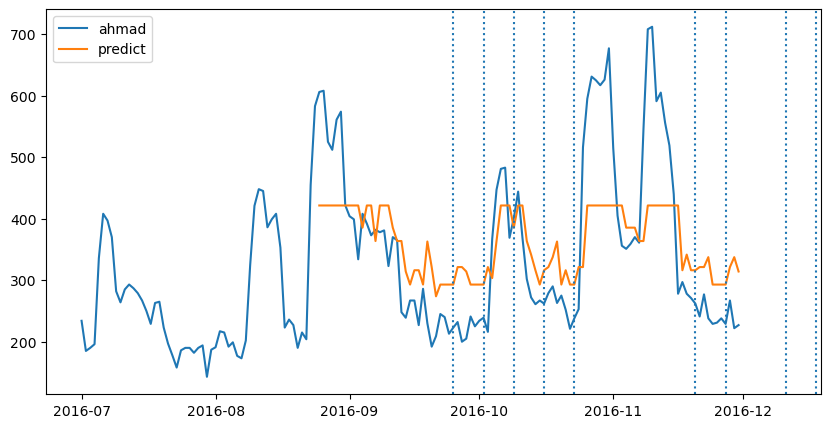

In [32]:
# Визуализируем полученные результаты
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['ahmad'])
ax.plot(df_test['Prediction'])

for release in map(convert_to_date, releases):
    ax.axvline(x=release, linestyle=':')
    
ax.legend(['ahmad', 'predict'])
plt.show()

Так же не наблюдаем взлёта продаж после выхода передач, относительно данных регрессии

#### Воспользуемся кластерным анализом

In [33]:
def getDistanceByPoint(data, model):
    """ Расчет расстояний от точек до центров кластеров """
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    distance = pd.Series(distance)    
    return distance

In [34]:
def get_clusters(df_source):
    """ Кластерный анализ """
    data = create_features(df_source)

    # Нормализуем наши данные
    starrd_scaler = preprocessing.StandardScaler().fit(data)
    np_scaled = starrd_scaler.transform(data)
    data = pd.DataFrame(np_scaled)

    # Уменьшим количество компонент
    pca = PCA(n_components=2)
    data = pca.fit_transform(data)

    min_max_scaler = preprocessing.StandardScaler().fit(data)
    np_scaled = min_max_scaler.transform(data)
    data = pd.DataFrame(np_scaled)

    kmeans = KMeans(n_clusters=4).fit(data)

    df_source['cluster'] = kmeans.predict(data)
    df_source['principal_feature1'] = np.array(data[0])
    df_source['principal_feature2'] = np.array(data[1])

    # Рассчитаем дистанцию до центра кластера
    distance = getDistanceByPoint(data, kmeans)
    number_of_outliers = int(outliers_fraction*len(distance))
    threshold = distance.nlargest(number_of_outliers).min()

    # Считаем точку аномалией, если расстояние до центра кластера больше порога
    df_source['anomaly'] = np.array((distance >= 3.0).astype(int))
    
    return df_source

ahmad


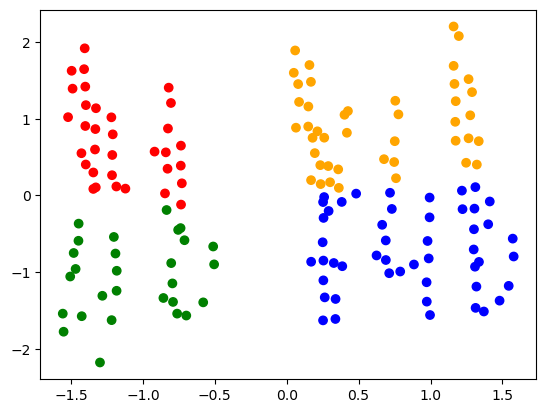

lipton


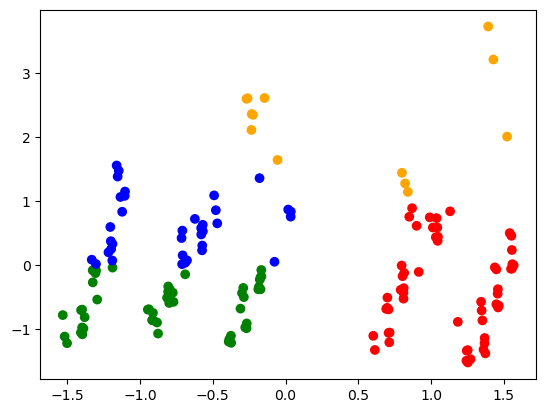

may


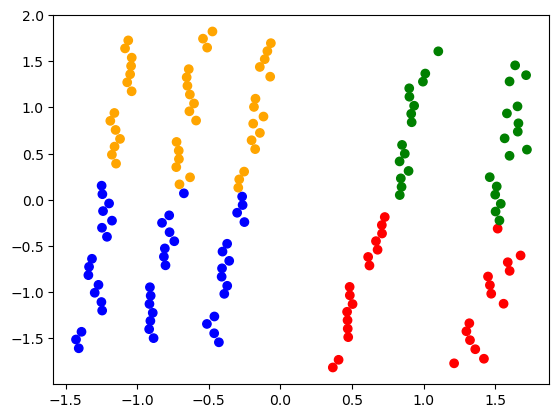

In [35]:
# Построим кластеры по трём вендорам
for series in ['ahmad', 'lipton', 'may']:
    print(series)
    df_cluster = get_clusters(pd.DataFrame(df[series]))
    fig, ax = plt.subplots()
    colors = {0:'red', 1:'blue', 2:'green', 3:'orange', 4:'cyan', 5:'yellow'}
    ax.scatter(df_cluster['principal_feature1'], df_cluster['principal_feature2'], c=df_cluster["cluster"].apply(lambda x: colors[x]))
    plt.show()

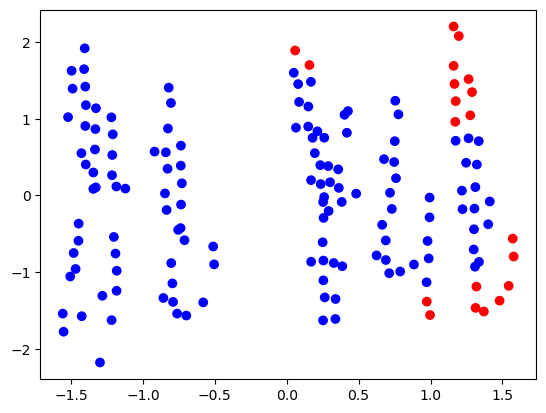

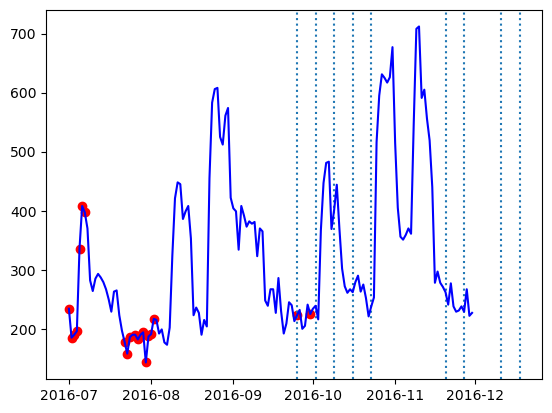

In [36]:
# Для вендора Ahmad отобразим выбросы на графике
df_cluster = get_clusters(pd.DataFrame(df['ahmad']))

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df_cluster['principal_feature1'], df_cluster['principal_feature2'], c=df_cluster["anomaly"].apply(lambda x: colors[x]))
plt.show()

fig, ax = plt.subplots()
# Выбросы
a = df_cluster.loc[df_cluster['anomaly'] == 1]['ahmad'].reset_index() 
# Передачи
for release in map(convert_to_date, releases):
    ax.axvline(x=release, linestyle=':')

ax.plot(df_cluster['ahmad'], color='blue')
ax.scatter(a['date'], a['ahmad'], color='red')
plt.show()

#### Вывод: Согласно анализу данных по продажам, можно сделать вывод, что реклама чая Ахмад в передаче "Что? Где? Когда?" не оказала существенного влияния